# **The Words of the Beast: An NLP Analysis of Iron Maiden Albums**
### Diego Surot de la Vega
### June 2024

<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=13Tqkkmn08NbItcX2gUrqh16aMrl-ahJQ" alt="image" width="75%">
</p>


## **Introduction**

My final project for the NLP course consisted on analysing Iron Maiden songs and albums. This project aims to explore the recurring themes and their evolution across Iron Maiden's albums, as well as to offer insights into the semantic richness and thematic shifts in their career.

The project is divided into 4 parts:
- Pre-processing
- Sentiment Analysis
- Topic Modeling
- PCA

## **Part 0: The dataset**

The dataset was created manually by grabbing the lyrics from AZLyrics. It contains **159** songs which span the entire Iron Maiden's discography; all the way from their first album Iron Maiden (1980), to their latest released album Senjutsu (2021).

The dataset contains the following columns:
- Song Title
- Album
- Release Year
- Lyrics

The following songs were left out of the dataset due to being 'instrumental' only:
- Transylvania - Iron Maiden, 1980
- The Ides of March - Killers, 1981
- Genghis Khan - Killers, 1981
- Losfer Words (Big 'Orra) - Powerslave, 1984

It is also important to note this dataset does not contain live albums, EPs, or special release editions, so only studio albums were considered for this project.




In [22]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re
import spacy
import nltk

from nltk.corpus import stopwords
from nltk import FreqDist

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

from textblob import TextBlob

# import torch
# from transformers import AutoTokenizer, pipeline, AutoModelForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [23]:
# #If you want to run this using Google Colab, please note it changes some of the results (I don't know why though)
# from google.colab import drive
# drive.mount('/content/drive')
# 
# df = pd.read_csv('/content/drive/MyDrive/Iron_Maiden_NLP/iron_maiden_lyrics.csv')

df = pd.read_csv('iron_maiden_lyrics.csv')
df.head()

,song_title,album,release_year,lyrics
0,Prowler,Iron Maiden,1980,Walking through the city\nLooking oh so pretty...
1,Sanctuary,Iron Maiden,1980,Out of winter came a warhorse of steel\nI've n...
2,Remember Tomorrow,Iron Maiden,1980,"Unchain the colours, before my eyes\nYesterday..."
3,Running Free,Iron Maiden,1980,"Just sixteen, a pickup truck\nOut of money, ou..."
4,Phantom Of The Opera,Iron Maiden,1980,I've been looking so long for you now\nYou won...


## **Part 1: Pre-processing and cleaning**

### **1.1. Cleaning and preparing the data**
In this part, I focused on removing brackets, punctuation, and line breakers. Additionally, I also removed stop words with an updated list of ignored words that were not covered by the NLTK library.

More importantly, given most songs have many repeated strings because of their chorus, I made the decision to keep only the first occurrence of a sentence.

In [24]:
def clean_token_lyrics(lyrics):
    lyrics = re.sub(r'\[.*?\]', '', lyrics)
    lyrics = re.sub(r'\(.*?\)', '', lyrics)
    lyrics = re.sub(r'[^\w\s]', '', lyrics).lower()
    lines = lyrics.split('\n')
    token_lines = [line.split() for line in lines]
    return token_lines

def remove_duplicate(token_lines):
    occurrence = set()
    unique_lines = []
    for line in token_lines:
        line_string = ' '.join(line)
        if line_string not in occurrence:
            occurrence.add(line_string)
            unique_lines.append(line)
    return unique_lines

# In here I had to add additional words that were not covered by stopwords from nltk
# I got an expanded list from (https://medium.com/@dimmakriss/natural-language-processing-and-sentiment-analysis-on-music-lyrics-7af53192945b) and added additional words that were not covered in it

upd_stopwords = set(stopwords.words('english')) | set(stopwords.words('spanish'))
upd_stopwords.update(['oh', 'ow', 'ooh', 'yeah', 'ha', 'youre', 'im', 'youve', 
                      'ive', 'gonna', 'dont', 'cant', 'doesnt', 'hes', 'shes', 
                      'or', 'm', 'ma', 'ours', 'against', 'nor', "it's", 'o', 
                      'wasn', 'hasn', 'my', 'had', 'didn', 'isn', 'did', 'aren', 
                      'those', 'than', "mustn't", "you've", 'to', 'she', 'having', 
                      "haven't", 'into', 't', 'll', 'himself', 'do', "that'll", 
                      'so', 'of', 'on', 'very', 'for', 'out', 'were', 'should', 
                      'they', 'ain', "should've", 'you', "didn't", 'yours', 'was', 
                      'our', 'can', 'myself', "shouldn't", 'have', 'up', 'mightn', 
                      "you'll", 'any', 'itself', 'hadn', 'him', 'doesn', 'weren', 
                      'y', 'being', "don't", 'them', 'are','and', 'that', 'your', 
                      'yourself', 'their', 'some', 'ourselves', 've', 'doing', 'been', 
                      'shouldn', 'yourselves', "mightn't", 'most', 'because','few', 
                      'wouldn', "you'd", 'through', "you're", 'themselves', 'an', 
                      'if',"wouldn't", 'its', 'other', "won't", "wasn't", "she's", 'us', 
                      'we', 'shan', "weren't",'don',"hadn't", 'this', 'off', 'while', 
                      'a', 'haven', 'her', 'theirs', 'all', "hasn't", "doesn't", 'about', 
                      'then', 'by','such', 'but', 'until', 'each', 'there', "aren't", 
                      'with', 'not', "shan't", 'hers', 'it', 'too', 'i', 'at', 'is', 
                      'as', 'me', 'herself', 's', 'the', 'where', 'am', 'has', 'over', 
                      "couldn't", 'when', 'does', 'mustn','re', 'no', 'in', 'who', 'd', 
                      'own', 'he', 'be', "isn't", 'his', 'these', 'same', 'whom', 'will', 
                      'needn','couldn', 'from', 'theres', 'aint', 've', 'til'])

def remove_stopwords(lines):
    return [[word for word in line if word not in upd_stopwords] for line in lines]

# Spacy did a better job than the Lemmatizer from NLTK
nlp = spacy.load('en_core_web_sm')

def lemma_lyrics(lines):
    lemma_lines = []
    for line in lines:
        doc = nlp(' '.join(line))
        lemma_line = [token.lemma_ for token in doc]
        lemma_lines.append(lemma_line)
    return lemma_lines

def process_lyrics(lyrics):
    token_lines = clean_token_lyrics(lyrics)
    unique_lines = remove_duplicate(token_lines)
    clean_lines = remove_stopwords(unique_lines)
    lemma_lines = lemma_lyrics(clean_lines)
    return ' '.join([' '.join(line) for line in lemma_lines])

df['clean_lyrics'] = df['lyrics'].apply(process_lyrics)

# We can check everything is alright now!
df.head()

,song_title,album,release_year,lyrics,clean_lyrics
0,Prowler,Iron Maiden,1980,Walking through the city\nLooking oh so pretty...,walk city look pretty get find way see lady fl...
1,Sanctuary,Iron Maiden,1980,Out of winter came a warhorse of steel\nI've n...,winter come warhorse steel never kill woman kn...
2,Remember Tomorrow,Iron Maiden,1980,"Unchain the colours, before my eyes\nYesterday...",unchain colour eye yesterday sorrow tomorrow w...
3,Running Free,Iron Maiden,1980,"Just sixteen, a pickup truck\nOut of money, ou...",sixteen pickup truck money luck get nowhere ca...
4,Phantom Of The Opera,Iron Maiden,1980,I've been looking so long for you now\nYou won...,look long will not get away grasp live long hi...


### **1.2. Calculating useful information and creating a new dataframe**
In here, I calculated values for different features, such as number of words before and after cleaning, number of unique words and ratio of unique words per album.

I also created a new dataframe called 'album_df' which contains the same information, but grouped by album. I would like to expand this project in the future, so I think it would be interesting to study the complexity of the songs and their evolution over time.

In [25]:
# Number of total words before and after cleaning
df['total_words_bc'] = df['lyrics'].str.split().str.len()
df['total_words_ac'] = df['clean_lyrics'].str.split().str.len()
df['unq_words_bc'] = df['lyrics'].apply(lambda x: len(set(x.split())))
df['unq_words_ac'] = df['clean_lyrics'].apply(lambda x: len(set(x.split())))

# Ratio of unique words
df['ratio_unq_bc'] = df['unq_words_bc'] / df['total_words_bc']
df['ratio_unq_ac'] = df['unq_words_ac'] / df['total_words_ac']

# The new df
album_df = df.groupby(['album', 'release_year']).agg({
    'total_words_bc': 'sum',
    'total_words_ac': 'sum',
    'unq_words_bc': 'sum',
    'unq_words_ac': 'sum',
    'ratio_unq_bc': 'mean',
    'ratio_unq_ac': 'mean'
}).reset_index().sort_values(by = 'release_year').reset_index(drop = True)

album_df

,album,release_year,total_words_bc,total_words_ac,unq_words_bc,unq_words_ac,ratio_unq_bc,ratio_unq_ac
0,Iron Maiden,1980,1547,471,649,341,0.465328,0.735602
1,Killers,1981,1979,669,841,460,0.431179,0.718609
2,The Number of the Beast,1982,2072,870,1121,654,0.545187,0.754655
3,Piece of Mind,1983,2150,782,957,592,0.468926,0.755404
4,Powerslave,1984,2120,801,977,598,0.456232,0.799926
5,Somewhere in Time,1986,2088,721,951,536,0.460846,0.743639
6,Seventh Son of a Seventh Son,1988,2125,759,982,573,0.467277,0.755951
7,No Prayer for the Dying,1990,2322,807,1084,646,0.492844,0.806130
8,Fear of the Dark,1992,3113,1015,1305,729,0.429447,0.733697
9,The X-Factor,1995,2708,954,1325,759,0.490494,0.809953


### **1.3. Number of words per album over the year**
Now we can compare the number of words in the albums over the years. By looking at this plot, we can see Iron Maiden gradually increased the amount of words per album over the years.

Unfortunately, other than the above, this bar plot does not offer much additional information for the analysis; however, I also included the number of words per album before and after cleaning, and found the reduction of words between one another to be quite significant, which I assume is due to the removal of repeated strings in the songs' choruses.

In [26]:
# Labels for plots moving forward
labels = album_df.apply(lambda row: f'{row["album"]} ({row["release_year"]})', axis = 1)
x = range(len(labels))

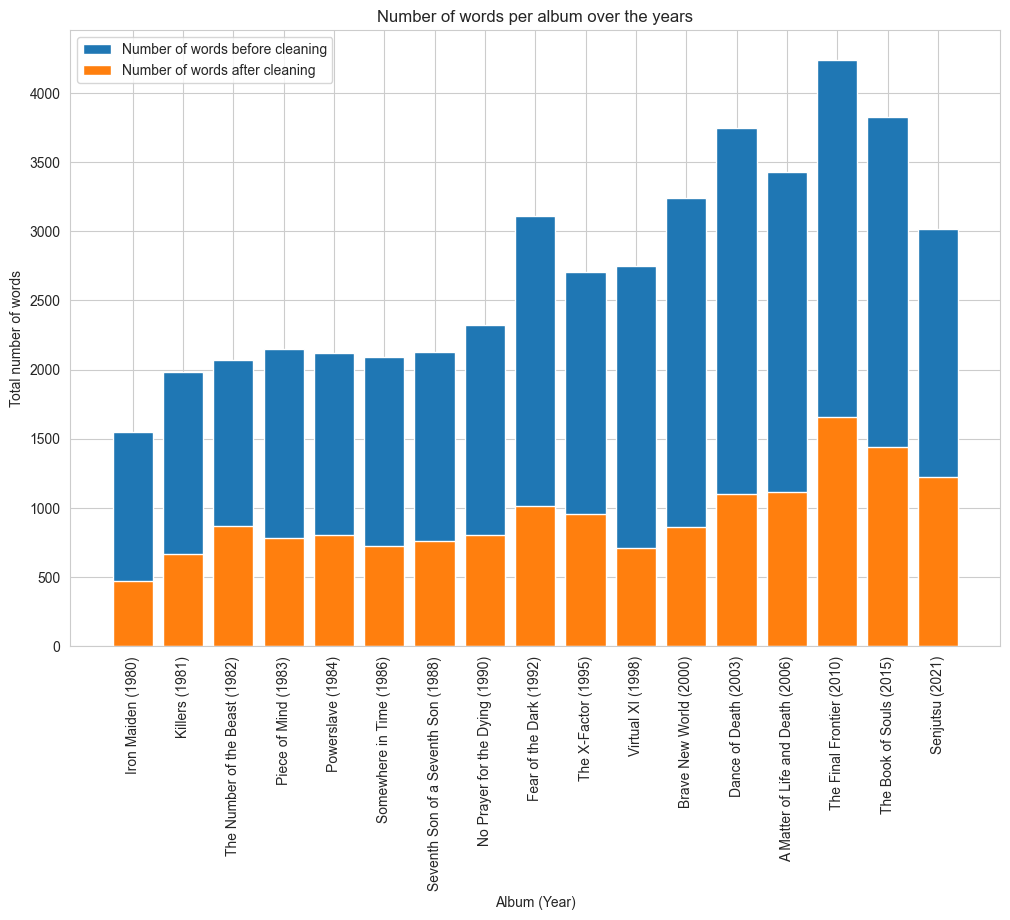

In [27]:
# The bar plot
plt.figure(figsize = (12, 8))
plt.bar(x, album_df['total_words_bc'], label = 'Number of words before cleaning')
plt.bar(x, album_df['total_words_ac'], label = 'Number of words after cleaning')
plt.xlabel('Album (Year)')
plt.ylabel('Total number of words')
plt.title('Number of words per album over the years')
plt.xticks(x, labels, rotation = 90)
plt.grid(True)
plt.legend()
plt.show()

### **1.4. Most frequent words per album**
As I am analysing Iron Maiden's discography based on their albums, my approach in here involved grouping the data by album and release years for further clarity. I then looked for the 3 most frequent words per album.

Preliminarily, when it comes to nouns, themes such as *'life', 'man', 'war', and 'time'* seem to be a staple in Iron Maiden songs. These words can initially be linked to themes such as *'time', 'conflict', and 'mortality'*, which is, according to my experience of listening to Iron Maiden, quite accurate!

As for verbs, it seems *'know', 'tell', and 'want', and 'get'* play an important role in their songs as well. This is interesting, as there is usually an underlying theme of self-awareness, introspection, and the pursuit of truth in their songs, for which *'want'* and *'know'* are perfect examples of.

Interestingly, for the album *'Seventh Son of a Seventh Son'*, the word *'seven'* was one of the most used, which definitely sets the perfect tone for its themes on prophecies and destiny.

In [28]:
# Getting the top 3 words per album
def top_words(lyrics, n = 3):
    token_words = nltk.word_tokenize(lyrics)
    freq_dist = FreqDist(token_words)
    return freq_dist.most_common(n)

album_df = df.groupby(['album', 'release_year'])['clean_lyrics'].apply(' '.join).reset_index()
album_df = album_df.sort_values(by = 'release_year').reset_index(drop = True)
album_df['top_words'] = album_df['clean_lyrics'].apply(lambda x: top_words(x))

# We can look at the words in here, but I think it's better to look at the plot below!
album_df[['album', 'release_year','top_words']]

,album,release_year,top_words
0,Iron Maiden,1980,"[(get, 15), (run, 13), (see, 11)]"
1,Killers,1981,"[(get, 27), (away, 15), (see, 13)]"
2,The Number of the Beast,1982,"[(man, 14), (come, 13), (know, 13)]"
3,Piece of Mind,1983,"[(die, 21), (fly, 10), (take, 10)]"
4,Powerslave,1984,"[(live, 13), (one, 12), (mariner, 11)]"
5,Somewhere in Time,1986,"[(go, 13), (get, 13), (feel, 13)]"
6,Seventh Son of a Seventh Son,1988,"[(seven, 19), (one, 14), (know, 13)]"
7,No Prayer for the Dying,1990,"[(get, 19), (go, 10), (one, 10)]"
8,Fear of the Dark,1992,"[(get, 24), (lie, 13), (go, 13)]"
9,The X-Factor,1995,"[(feel, 17), (get, 13), (war, 13)]"


In [29]:
# Colors for plots moving forward
albums = df['album'].unique()
palette = sns.color_palette('hsv', len(albums))
color_dict = {album: palette[i] for i, album in enumerate(albums)}

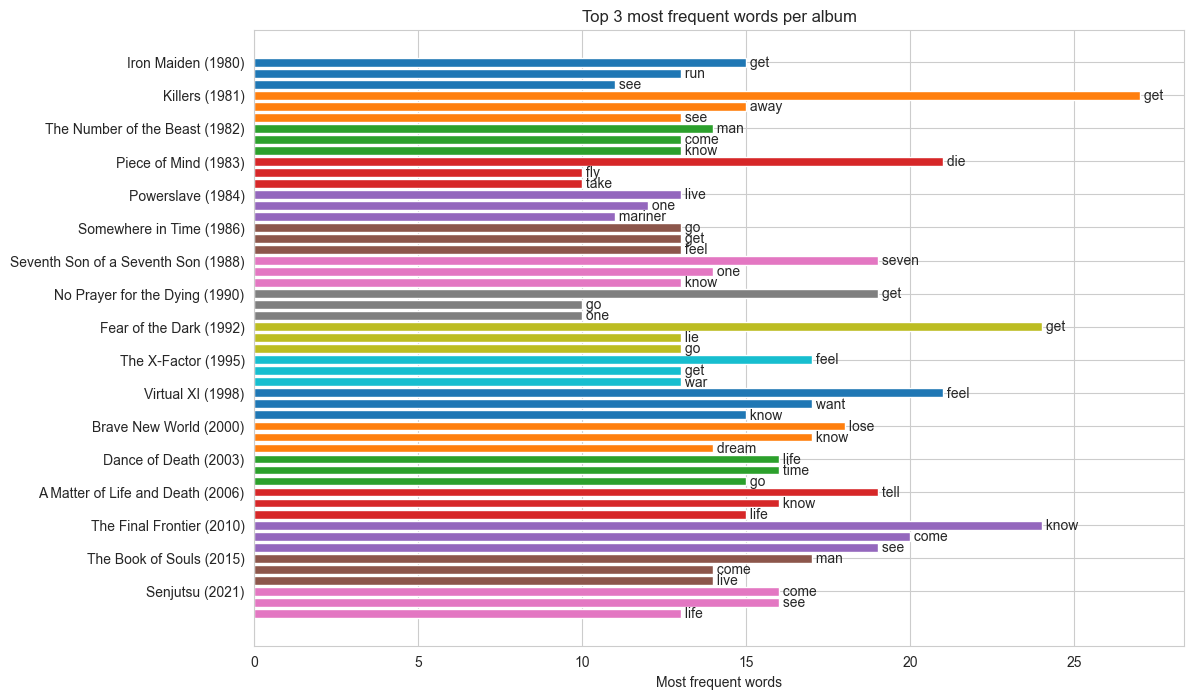

In [30]:
# Plotting them
# There's a problem with Google Colab here, as it doesn't have enough colors, and it's possible two albums have the same one
plt.figure(figsize = (12, 8))

for index, row in album_df.iterrows():
    top_words = row['top_words']

    words = [word for word, count in top_words]
    counts = [count for word, count in top_words]

    y_axis = [index * 3 + i for i in range(len(words))]
    color = color_dict[row['album']]
    plt.barh(y_axis, counts, label = row['album'])
    
    for i, word in enumerate(words):
        plt.text(counts[i], y_axis[i], f' {word}', va = 'center')

plt.yticks(range(0, len(album_df) * 3, 3), labels)
plt.xlabel('Most frequent words')
plt.grid(True)
plt.title('Top 3 most frequent words per album')
plt.gca().invert_yaxis()
plt.show()

### **1.5. Most frequent words in the entire discography**

In [31]:
# Putting all lyrics together to create a giant string
full_lyrics = ' '.join(df['clean_lyrics'])

# Getting the top 50 words per album
def top50_words(lyrics, n = 50):
    token_words = nltk.word_tokenize(lyrics)
    freq_dist = FreqDist(token_words)  
    return freq_dist.most_common(n)

top_50 = top50_words(full_lyrics, 50)
words = [word for word, count in top_50]
counts = [count for word, count in top_50]

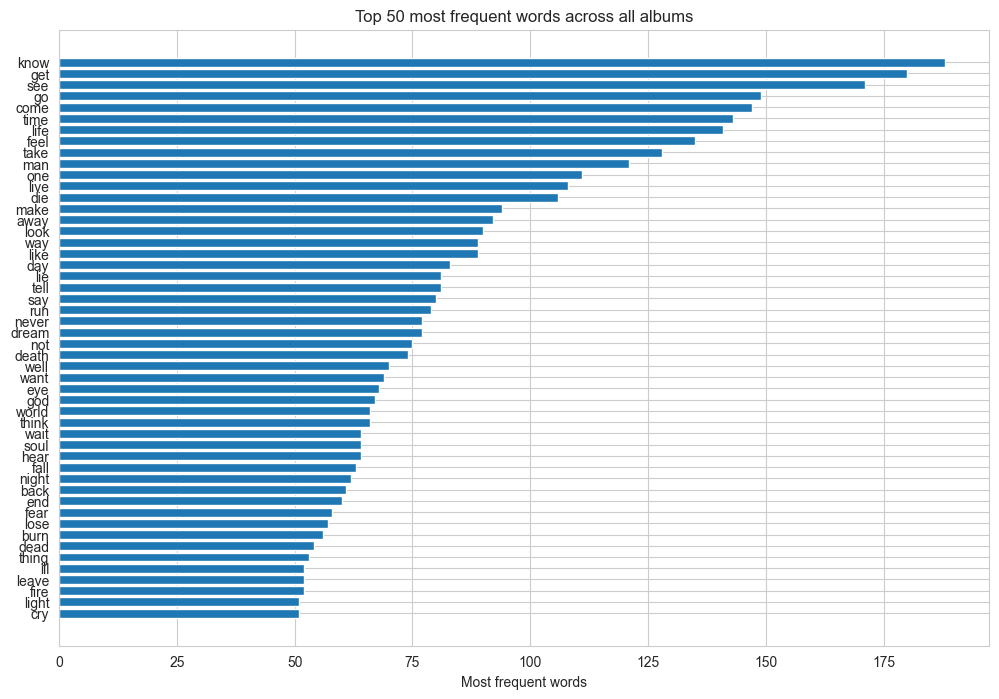

In [32]:
# Plotting
plt.figure(figsize = (12, 8))
plt.barh(words, counts, align = 'center')
plt.xlabel('Most frequent words')
plt.title('Top 50 most frequent words across all albums')
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

## **Part 2: Sentiment Analysis**

### **Part 2.1. Getting the Sentiment Scores**
In this section, I am labeling each song with their corresponding sentiment score. My first approach was using a trained model from HuggingFace, but unfortunately, every model I tried was specifically designed for binary outputs, so labeling each song with either 'positive' or 'negative' labels felt extremely reductive.

With that in mind, I defaulted to TextBlob, which offers polarity scores (1 for positive, -1 for negative) and felt more appropriate for the task at hand. As we can see later, when I plotted these scores in a scatter plot, most of the songs stay closer to neutral scores, rather than taking a positive or negative stance.

In [33]:
# # This was my first approach using siebert
# tokenizer = AutoTokenizer.from_pretrained('siebert/sentiment-roberta-large-english')
# model = AutoModelForSequenceClassification.from_pretrained('siebert/sentiment-roberta-large-english')
# sentiment_analysis = pipeline('sentiment-analysis', model=model, tokenizer = tokenizer)

In [34]:
# df['sentiment_score'] = df['clean_lyrics'].apply(lambda x: sentiment_analysis(x)[0]['label'])
# 
# print(df[['clean_lyrics', 'sentiment_score']]

In [35]:
# This is the second approach using TextBlob
def analyse_sentiment(lyrics):
    blob = TextBlob(lyrics)
    return blob.sentiment.polarity

df['sentiment_score'] = df['clean_lyrics'].apply(analyse_sentiment)

df[['song_title', 'sentiment_score']]

,song_title,sentiment_score
0,Prowler,0.087500
1,Sanctuary,-0.039286
2,Remember Tomorrow,0.252000
3,Running Free,0.298214
4,Phantom Of The Opera,-0.114876
...,...,...
155,The Time Machine,-0.143892
156,Darkest Hour,-0.074242
157,Death Of The Celts,0.250319
158,The Parchment,0.181187


### **2.2. Scatter plotting songs according to their sentiment scores**
After calculating a sentiment score for each song, I used a scatter plot to help with visualisation. We can now see Iron Maiden songs stay pretty neutral for the most part, which I believe is more accurate and fits the themes of their songs much better than a binary categorization.

In [36]:
# grouping and updating album_df
album_sentiment = df.groupby('album')['sentiment_score'].mean().reset_index()
album_df = album_df.merge(album_sentiment, on = 'album')

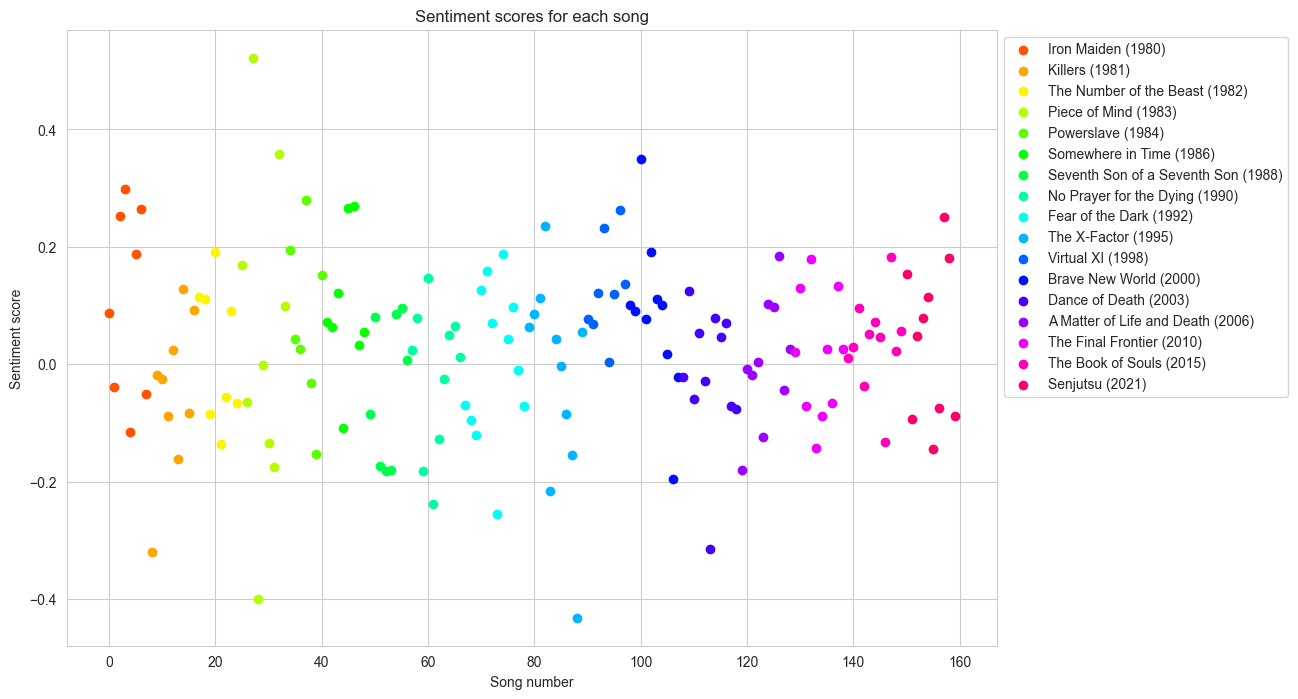

In [37]:
# Scatter
plt.figure(figsize = (12, 8))

for album in albums:
    subset = df[df['album'] == album]
    album_label = labels[albums.tolist().index(album)]
    plt.scatter(subset.index, subset['sentiment_score'], # release_year would have been best for the x axis, but it destroys the plot
                color = color_dict[album], label = album_label)

plt.xlabel('Song number')
plt.ylabel('Sentiment score')
plt.title('Sentiment scores for each song')
plt.legend(bbox_to_anchor = (1, 1))
plt.show()

### **2.3. Bar plotting sentiment scores by albums**
When it comes to positive scores, *'Virtual XI'* and *'Iron Maiden'* come on top. As for negative scores, the album *'Killers'* takes the top spot, followed closely by *'Seventh Son of a Seventh Son'*. Nevertheless, every album stays relatively close to a neutral position.

In [38]:
album_df[['album', 'sentiment_score']]

,album,sentiment_score
0,Iron Maiden,0.110597
1,Killers,-0.049907
2,The Number of the Beast,0.020102
3,Piece of Mind,0.041671
4,Powerslave,0.072643
5,Somewhere in Time,0.096318
6,Seventh Son of a Seventh Son,-0.044007
7,No Prayer for the Dying,-0.019440
8,Fear of the Dark,0.005148
9,The X-Factor,-0.026834


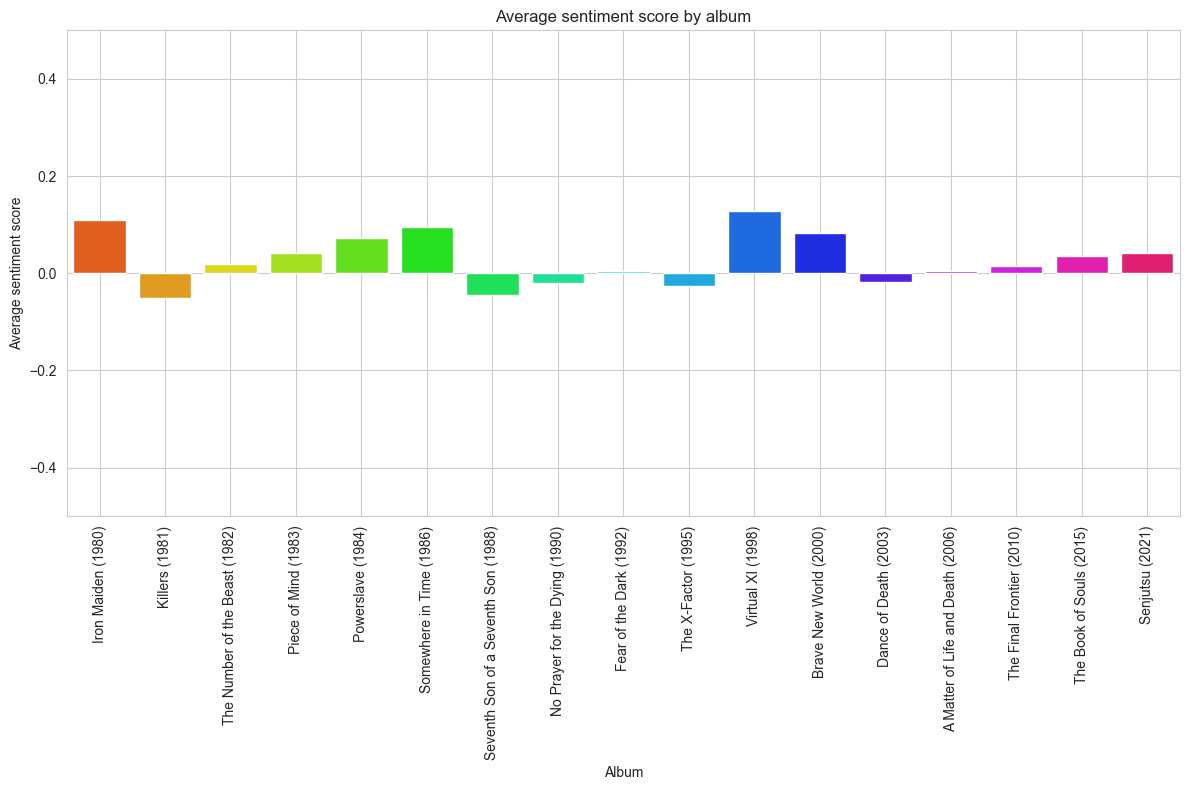

In [39]:
# Bar plot
plt.figure(figsize = (12, 8))
sns.barplot(data = album_df, x = labels, y = 'sentiment_score',
            hue = 'album', palette = [color_dict[album] for album in album_df['album']],
            legend = False)
plt.xlabel('Album')
plt.ylabel('Average sentiment score')
plt.ylim(-.5, .5)
plt.title('Average sentiment score by album')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.grid(True)
plt.show()

## **Part 3: Topic Modeling**

### **3.1. Extracting topics of Iron Maiden songs**

In this section, I used LDA to extract the main themes used in Iron Maiden songs. I had initially settled for 5 topics; however, it was common to encounter the same words in two or three of the topics, so I went with 3 in the end with 10 words each for additional variety.

In [40]:
# Vectorization
# In here I struggled with whether to pass the 'stop_words' argument or not, but I went with yes because of additional stop words that might have been skipped by Spacy
# It's important to note that the inclusion or not inclusion of this hyperparameter influences the final outcome
count_vectorizer = CountVectorizer(stop_words = 'english')
count_data = count_vectorizer.fit_transform(df['clean_lyrics'])

# Applying LDA
# I settled for random_state = 42 for the sake of consistency with the written analysis, but other states provide similar results
lda = LatentDirichletAllocation(n_components = 3, random_state = 42)
lda_results = lda.fit_transform(count_data)

# New df with LDA results
lda_df = pd.DataFrame(lda_results, index = df['song_title'])
word_topics = count_vectorizer.get_feature_names_out()

# Topics and their words organized in terms of importance
for t, topic in enumerate(lda.components_):
    print(f'Topics {t}:')
    print([word_topics[topic] for topic in topic.argsort()[-10:][::-1]])

# We can also see how each topic influences each song
lda_df

Topics 0:
['die', 'man', 'know', 'live', 'life', 'hell', 'come', 'god', 'tell', 'fight']
Topics 1:
['know', 'feel', 'come', 'time', 'life', 'away', 'look', 'live', 'like', 'want']
Topics 2:
['man', 'know', 'life', 'time', 'way', 'day', 'lie', 'death', 'come', 'run']


,0,1,2
song_title,,,
Prowler,0.012251,0.976286,0.011463
Sanctuary,0.009119,0.980787,0.010094
Remember Tomorrow,0.011746,0.013101,0.975153
Running Free,0.007985,0.008819,0.983196
Phantom Of The Opera,0.005739,0.988553,0.005708
...,...,...,...
The Time Machine,0.003907,0.991918,0.004176
Darkest Hour,0.004891,0.990137,0.004972
Death Of The Celts,0.002883,0.994166,0.002951


### **3.2. Interpretation of topics**

Please note this section is an interpretation of the words that are more prominent in each topic accentuated by my experience as a fan of the band. All things considered, I am quite satisfied with these results as they preliminarily align with the predominant themes of each album.

When it comes to Topic 0, words like *'die', 'fight', 'man', and 'live'* suggest a theme of conflict between men, but also suggest a theme of spirituality is present as well, given the words 'god' and 'hell'. Songs like *'Afraid to Shoot Strangers', 'Die With Your Boots On', and 'The Book of Souls'* are perfect examples for this category.

Topic 1 seems to be about the experience of emotions, as most of the words in it are verbs. Words like *'feel', 'know', 'come', 'look', and 'live'* suggest there is a theme of looking to express emotions as a result of experiences. Songs such as *'Wrathchild', 'Hallowed Be Thy Name', and 'The Thin Line Between Love and Hate'* suit this category.

Finally, for Topic 2, words such as *'man', 'life', 'death', 'run', 'time', and 'lie'* could suggest a need for escape out of a conflict associated with death (mortality?). *'Revelations', 'Run to the Hills', and 'The Evil that Men Do'* fit this category.

## **Part 4: PCA**

### **4.1. Applying PCA to Topics from LDA**

I admit I am a bit shaky on this part, as it was mostly experimental product of trying something new. I applied PCA to the results from LDA (3 topics) which reduces the proportions of topics into principal components.

By looking at the loadings of the principal components, we can look at how much of the original 3 topics contribute to each of the 3 principal components. My interpretation of this is that if an album scores high on PC1, it is more associated with Topic 2 (Escape, Conflict, and Mortality) rather than with Topic 1 (Experiences and Emotions). At the same time, if an album scores high on PC2, it is more heavily associated with Topic 0 (Conflict and Spirituality) rather than with the themes of Topics 1 and 2. Finally, a high score on PC3 indicates an album is perfectly balanced between all 3 topics.

In [41]:
# Applying PCA to the results from LDA (3 topics)
pca = PCA(n_components = 3)
pca_results = pca.fit_transform(lda_df)

# new df with pca results
pca_df = pd.DataFrame(pca_results, columns = ['PC1', 'PC2', 'PC3'], index = df['album'])

# We can look at the loading of each PC onto every topic 
loadings_df = pd.DataFrame(pca.components_.T, index = ['Topic 0', 'Topic 1', 'Topic 2'], columns = ['PC1', 'PC2', 'PC3'])
loadings_df

,PC1,PC2,PC3
Topic 0,0.061661,0.814165,0.57735
Topic 1,-0.735918,-0.353683,0.57735
Topic 2,0.674257,-0.460482,0.57735


### **4.2. PCA Plot**

This 3D plot groups album according to their PCA scores. Albums that are clustered together, such as *Dance of Death* and *The Book of Souls*, and *Fear of the Dark* and *Brave New World* have similar themes in their songs.

Additionally, there are unique albums which seem to be different from other entries. Clear examples of this are *Seventh Son of a Seventh Son (best album!), Iron Maiden, and Powerslave*.

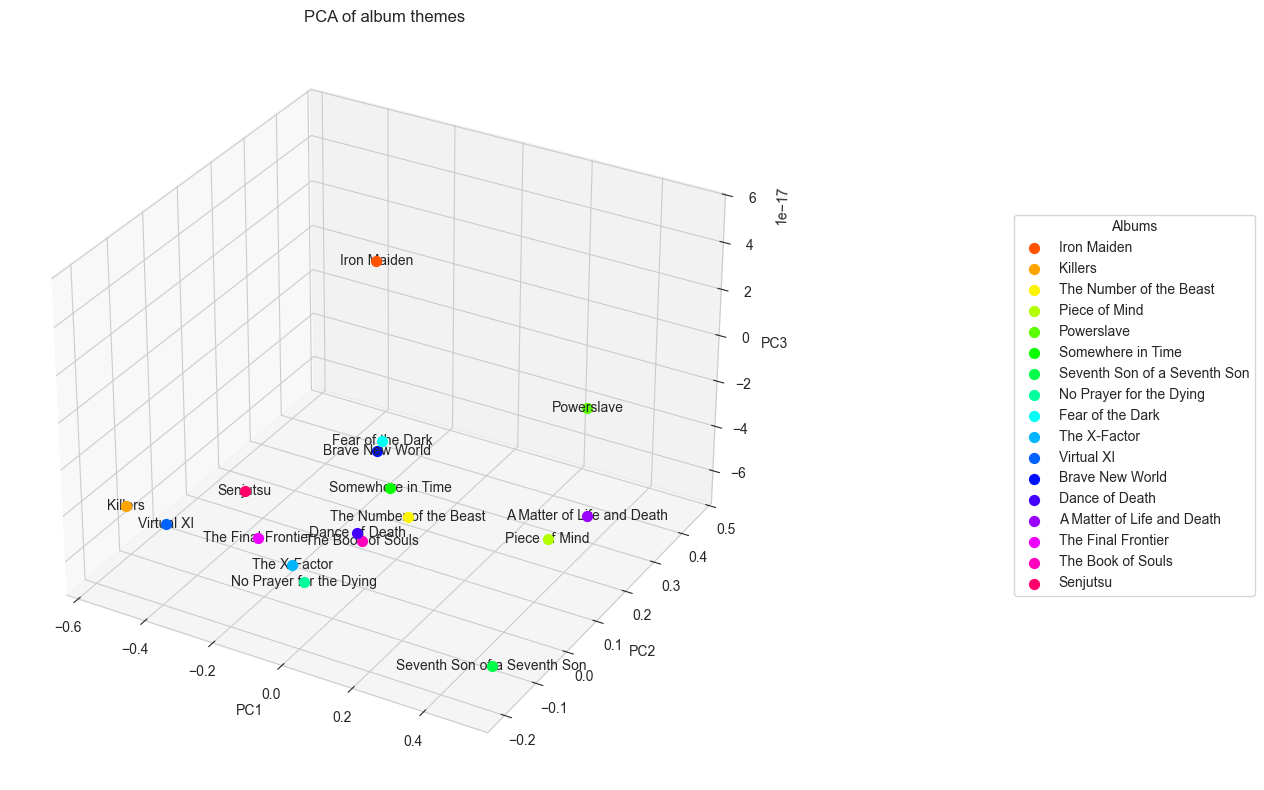

In [42]:
# Plotting
sns.set_style('whitegrid')
pca_df_mean = pca_df.groupby(pca_df.index).mean()

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = '3d')

for album in pca_df.index.unique():
    subset = pca_df_mean.loc[album]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'],
               color = color_dict[album], s = 50, label = album)
    ax.text(subset['PC1'], subset['PC2'], subset['PC3'],
            album, fontsize = 10, va = 'center', ha = 'center')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.set_title('PCA of album themes')
ax.legend(title = 'Albums', loc = 'center', bbox_to_anchor = (1.5, .5))

plt.tight_layout()
plt.show()

## **Final Thoughts**

This project provides insights into the themes of Iron Maiden's albums. By identifying frequent words, it was possible to highlight different themes that are a staple of Iron Maiden's songs. As a huge fan of the band, this project helped to reveal all the little details that are usually hidden in their songs, while at the same time it provided an opportunity for learning and putting NLP techniques to good use.

While I believe my analysis covers a good part of the work, there is probably room for improvement. Analysing the lyrics provides extremely useful insights as to what the recurrent themes of a band are, but it is probably lacking an even more important part, the music! It would be interesting to expand this project in the future and see how these results can be correlated with, for example, the beat of the songs.

Finally, I would like to thank for the opportunity to apply NLP to a topic of our choice. This enriched the experience and made the entire process much more rewarding.
